
## Dependencies

## Imports

In [ ]:
import os
import csv 
import time
import argparse

import os
import sys
sys.path.append('.')

import numpy as np
import numba as nb
from tqdm import tqdm
import multiprocessing

import torch
import torch.optim as optim
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch_scatter
import spconv.pytorch as spconv

import MinkowskiEngine as ME
from utils.metric_util import per_class_iu, fast_hist_crop
from utils.lovasz_losses import lovasz_softmax

from dataloader.pc_dataset import get_SemKITTI_label_name
from dataloader.dataset_semantickitti import get_model_class as get_model_class_dataset, collate_fn_BEV
from dataloader.pc_dataset import get_pc_model_class

from config.config import load_config_data

from utils.load_save_util import load_checkpoint

from models_.modules.common import ConvType, NormType, get_norm, conv, get_nonlinearity_fn
from models_.modules.resnet_block import *

import warnings
warnings.filterwarnings("ignore")
#print(torch.__version__)
pytorch_device = torch.device('cuda:0')

## Cylinder3D - Architecture -First Part -> Second Part
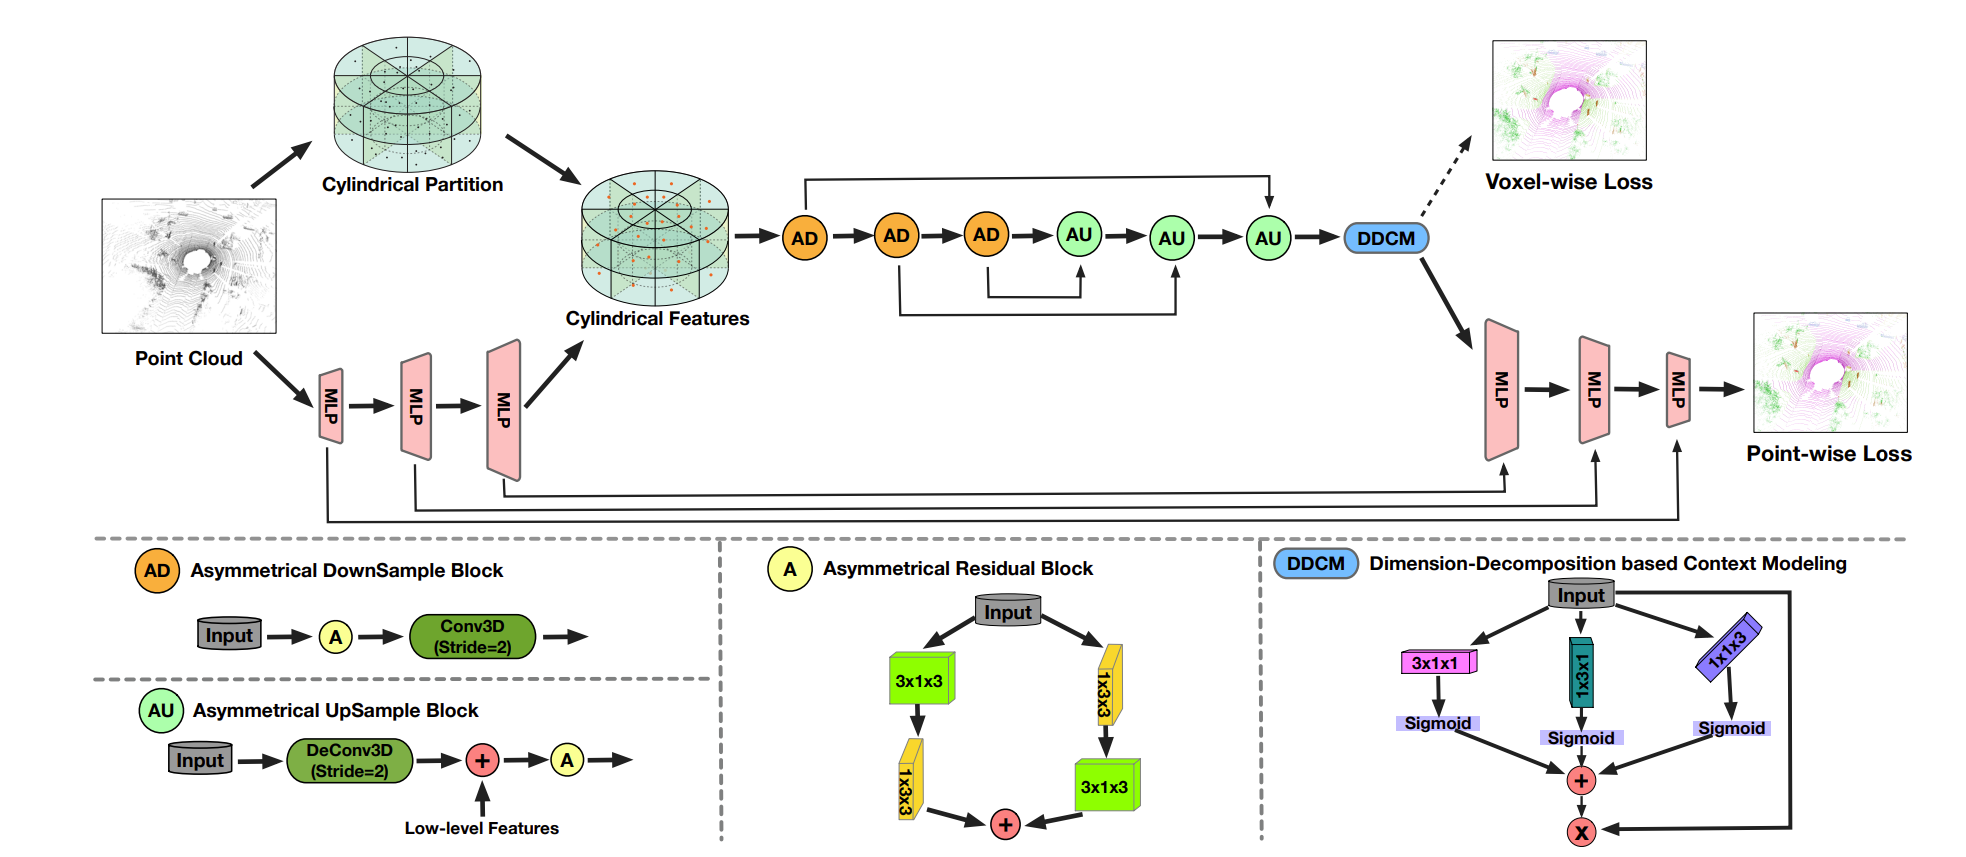

In [ ]:
REGISTERED_MODELS_CLASSES = {}

def register_model(cls, name=None):
    global REGISTERED_MODELS_CLASSES
    if name is None:
        name = cls.__name__
    assert name not in REGISTERED_MODELS_CLASSES, f"exist class: {REGISTERED_MODELS_CLASSES}"
    REGISTERED_MODELS_CLASSES[name] = cls
    return cls


def get_model_class_c3d(name):
    global REGISTERED_MODELS_CLASSES
    assert name in REGISTERED_MODELS_CLASSES, f"available class: {REGISTERED_MODELS_CLASSES}"
    return REGISTERED_MODELS_CLASSES[name]


@register_model
class cylinder_asym(nn.Module):
    def __init__(self,
                 cylin_model,
                 segmentator_spconv,
                 sparse_shape,
                 ):
        super().__init__()
        self.name = "cylinder_asym"

        self.cylinder_3d_generator = cylin_model             # Network Architecture - First Part
        self.cylinder_3d_spconv_seg = segmentator_spconv     # Network Architecture - Second Part

        self.sparse_shape = sparse_shape

    def forward(self, train_pt_fea_ten, train_vox_ten, batch_size, iter):
        coords, features_3d = self.cylinder_3d_generator(train_pt_fea_ten, train_vox_ten)   # Network Architecture - First Part
        spatial_features = self.cylinder_3d_spconv_seg(features_3d, coords, batch_size, iter)     # Network Architecture - Second Part

        return spatial_features


## Segmentator 3D Asymmetric Sparse Convolution 3D

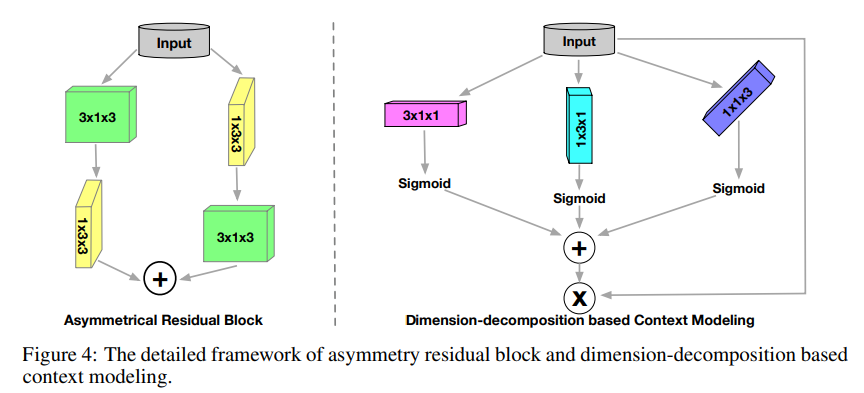

In [ ]:
##########################################################################################
# ASYMMETRIC CONVOLUTIONS                                                                #
##########################################################################################

def conv3x3(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=3, stride=stride,
                             padding=1, bias=False, indice_key=indice_key)


def conv1x3(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=(1, 3, 3), stride=stride,
                             padding=(0, 1, 1), bias=False, indice_key=indice_key)


def conv1x1x3(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=(1, 1, 3), stride=stride,
                             padding=(0, 0, 1), bias=False, indice_key=indice_key)


def conv1x3x1(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=(1, 3, 1), stride=stride,
                             padding=(0, 1, 0), bias=False, indice_key=indice_key)


def conv3x1x1(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=(3, 1, 1), stride=stride,
                             padding=(1, 0, 0), bias=False, indice_key=indice_key)


def conv3x1(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=(3, 1, 3), stride=stride,
                             padding=(1, 0, 1), bias=False, indice_key=indice_key)


def conv1x1(in_planes, out_planes, stride=1, indice_key=None):
    return spconv.SubMConv3d(in_planes, out_planes, kernel_size=1, stride=stride,
                             padding=1, bias=False, indice_key=indice_key)


##########################################################################################
# ResContextBlock - Used before going into the first DownSample Block.                   #
##########################################################################################

class ResContextBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=(3, 3, 3), stride=1, indice_key=None):
        super(ResContextBlock, self).__init__()
        self.conv1 = conv1x3(in_filters, out_filters, indice_key=indice_key + "bef")
        self.bn0 = nn.BatchNorm1d(out_filters)
        self.act1 = nn.LeakyReLU()
          
        #self.conv1_2 = conv3x1(out_filters, out_filters, indice_key=indice_key + "bef")
        self.conv1_2 = conv1x3(out_filters, out_filters, indice_key=indice_key + "bef")

        self.bn0_2 = nn.BatchNorm1d(out_filters)
        self.act1_2 = nn.LeakyReLU()

        self.conv2 = conv3x1(in_filters, out_filters, indice_key=indice_key + "bef")
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(out_filters)

        #self.conv3 = conv1x3(out_filters, out_filters, indice_key=indice_key + "bef")
        self.conv3 = conv3x1(out_filters, out_filters, indice_key=indice_key + "bef")
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm1d(out_filters)

        self.weight_initialization()

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = shortcut.replace_feature(self.act1(shortcut.features))
        shortcut = shortcut.replace_feature(self.bn0(shortcut.features))

        shortcut = self.conv1_2(shortcut)
        shortcut = shortcut.replace_feature(self.act1_2(shortcut.features))
        shortcut = shortcut.replace_feature(self.bn0_2(shortcut.features))

        resA = self.conv2(x)
        resA = resA.replace_feature(self.act2(resA.features))
        reaA = resA.replace_feature(self.bn1(resA.features))

        resA = self.conv3(resA)
        resA = resA.replace_feature(self.act3(resA.features))
        resA = resA.replace_feature(self.bn2(resA.features))
        resA = resA.replace_feature(resA.features + shortcut.features)

        return resA
    

##########################################################################################
# ResBlock - Used to create DownSample Blocks. There are originally 4 DownSample Blocks. #
##########################################################################################

class ResBlock(nn.Module):
    def __init__(self, in_filters, out_filters, dropout_rate, kernel_size=(3, 3, 3), stride=1,
                 pooling=True, drop_out=True, height_pooling=False, indice_key=None):
        super(ResBlock, self).__init__()
        self.pooling = pooling
        self.drop_out = drop_out

        self.conv1 = conv3x1(in_filters, out_filters, indice_key=indice_key + "bef")
        self.act1 = nn.LeakyReLU()
        self.bn0 = nn.BatchNorm1d(out_filters)

        #self.conv1_2 = conv1x3(out_filters, out_filters, indice_key=indice_key + "bef")
        self.conv1_2 = conv3x1(out_filters, out_filters, indice_key=indice_key + "bef")
        self.act1_2 = nn.LeakyReLU()
        self.bn0_2 = nn.BatchNorm1d(out_filters)

        self.conv2 = conv1x3(in_filters, out_filters, indice_key=indice_key + "bef")
        self.act2 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(out_filters)

        #self.conv3 = conv3x1(out_filters, out_filters, indice_key=indice_key + "bef")
        self.conv3 = conv1x3(out_filters, out_filters, indice_key=indice_key + "bef")
        self.act3 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm1d(out_filters)

        if pooling:
            if height_pooling:
                self.pool = spconv.SparseConv3d(out_filters, out_filters, kernel_size=3, stride=2,
                                                padding=1, indice_key=indice_key, bias=False)
            else:
                self.pool = spconv.SparseConv3d(out_filters, out_filters, kernel_size=3, stride=(2, 2, 1),
                                                padding=1, indice_key=indice_key, bias=False)
        self.weight_initialization()

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = shortcut.replace_feature(self.act1(shortcut.features))
        shortcut = shortcut.replace_feature(self.bn0(shortcut.features))

        shortcut = self.conv1_2(shortcut)
        shortcut = shortcut.replace_feature(self.act1_2(shortcut.features))
        shortcut = shortcut.replace_feature(self.bn0_2(shortcut.features))

        resA = self.conv2(x)
        resA = resA.replace_feature(self.act2(resA.features))
        resA = resA.replace_feature(self.bn1(resA.features))

        resA = self.conv3(resA)
        resA = resA.replace_feature(self.act3(resA.features))
        resA = resA.replace_feature(self.bn2(resA.features))

        resA = resA.replace_feature(resA.features + shortcut.features)

        if self.pooling:
            resB = self.pool(resA)
            return resB, resA
        else:
            return resA


##########################################################################################
# UpSample Block. There are originally 4 UpSample Blocks                                 #
##########################################################################################

class UpBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=(3, 3, 3), indice_key=None, up_key=None):
        super(UpBlock, self).__init__()
        # self.drop_out = drop_out
        self.trans_dilao = conv3x3(in_filters, out_filters, indice_key=indice_key + "new_up")
        self.trans_act = nn.LeakyReLU()
        self.trans_bn = nn.BatchNorm1d(out_filters)

        self.conv1 = conv1x3(out_filters, out_filters, indice_key=indice_key)
        self.act1 = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(out_filters)

        #self.conv3 = conv3x1(out_filters, out_filters, indice_key=indice_key + "bef")
        self.conv2 = conv1x3(out_filters, out_filters, indice_key=indice_key)
        self.act2 = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm1d(out_filters)

        #self.conv3 = conv3x3(out_filters, out_filters, indice_key=indice_key)
        self.conv3 = conv1x3(out_filters, out_filters, indice_key=indice_key)
        self.act3 = nn.LeakyReLU()
        self.bn3 = nn.BatchNorm1d(out_filters)
        # self.dropout3 = nn.Dropout3d(p=dropout_rate)

        self.up_subm = spconv.SparseInverseConv3d(out_filters, out_filters, kernel_size=3, indice_key=up_key,
                                                  bias=False)

        self.weight_initialization()

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, skip):
        upA = self.trans_dilao(x)
        upA = upA.replace_feature(self.trans_act(upA.features))
        upA = upA.replace_feature(self.trans_bn(upA.features))

        ## upsample
        upA = self.up_subm(upA)

        upA = upA.replace_feature(upA.features + skip.features)

        upE = self.conv1(upA)
        upE = upE.replace_feature(self.act1(upE.features))
        upE = upE.replace_feature(self.bn1(upE.features))

        upE = self.conv2(upE)
        upE = upE.replace_feature(self.act2(upE.features))
        upE = upE.replace_feature(self.bn2(upE.features))

        upE = self.conv3(upE)
        upE = upE.replace_feature(self.act3(upE.features))
        upE = upE.replace_feature(self.bn3(upE.features))

        return upE
    
    
##########################################################################################
# DDCM - Figure 4 (right hand side) and architecture Figure: after last U block          #
##########################################################################################

class ReconBlock(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=(3, 3, 3), stride=1, indice_key=None):
        super(ReconBlock, self).__init__()
        self.conv1 = conv3x1x1(in_filters, out_filters, indice_key=indice_key + "bef")
        self.bn0 = nn.BatchNorm1d(out_filters)
        self.act1 = nn.Sigmoid()

        self.conv1_2 = conv1x3x1(in_filters, out_filters, indice_key=indice_key + "bef")
        self.bn0_2 = nn.BatchNorm1d(out_filters)
        self.act1_2 = nn.Sigmoid()

        self.conv1_3 = conv1x1x3(in_filters, out_filters, indice_key=indice_key + "bef")
        self.bn0_3 = nn.BatchNorm1d(out_filters)
        self.act1_3 = nn.Sigmoid()

    def forward(self, x):
        shortcut = self.conv1(x)
        shortcut = shortcut.replace_feature(self.bn0(shortcut.features))
        shortcut = shortcut.replace_feature(self.act1(shortcut.features))

        shortcut2 = self.conv1_2(x)
        shortcut2 = shortcut2.replace_feature(self.bn0_2(shortcut2.features))
        shortcut2 = shortcut2.replace_feature(self.act1_2(shortcut2.features))

        shortcut3 = self.conv1_3(x)
        shortcut3 = shortcut.replace_feature(self.bn0_3(shortcut3.features))
        shortcut3 = shortcut3.replace_feature(self.act1_3(shortcut3.features))
        shortcut = shortcut.replace_feature(shortcut.features + shortcut2.features + shortcut3.features)

        shortcut = shortcut.replace_feature(shortcut.features * x.features)

        return shortcut

## Transformer Blocks from CodedVTR
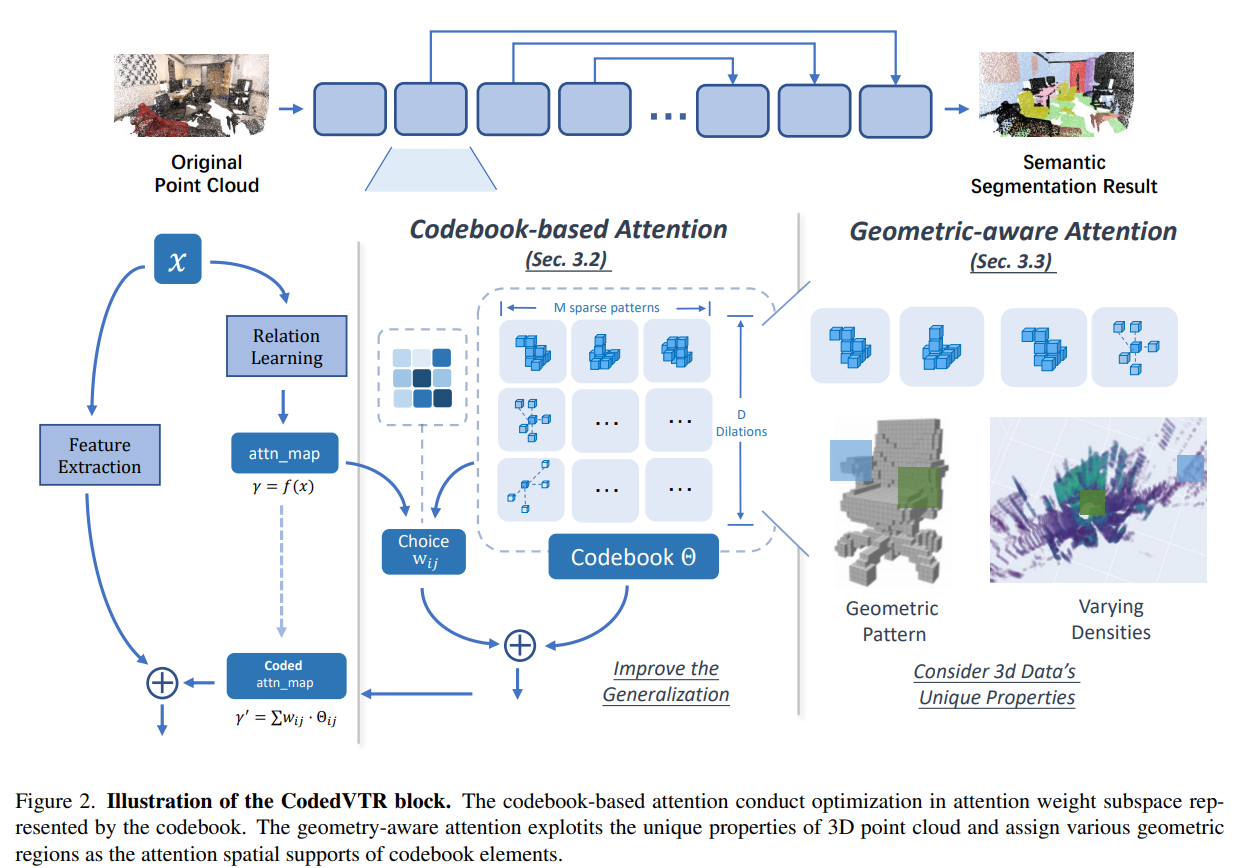

In [ ]:
##########################################################################################
# Transformer Block from CodedVTR                                                        #
##########################################################################################

class CodedVTRBlock(nn.Module): # ddp could not contain unused parameter, so donnot inherit from TRBlock
    expansion=1
    def __init__(self,
               inplanes,
               planes,
               stride=1,
               dilation=1,
               downsample=None,
               conv_type=ConvType.HYPERCUBE,
               nonlinearity_type='ReLU',
               bn_momentum=0.1,
               D=3):

        super(CodedVTRBlock, self).__init__()

        self.inplanes = inplanes
        self.planes = planes
        '''
        The Codebook-based Attention: for original feature [1, dim], generate the attnmap [K,h];
        then do dotproduct with codebook [D,M,K,dim], get choice [D,M], use it to aggregate the codebook;
        apply on value [1, dim] to generate final feature
        ------------------
        inplanes/outplanes: the feature dim
        expansion: the width expansion
        qk_type:
            - conv
            - dotproduct(pairwise)
        conv_v: use conv or linear for gen value
        vec_dim: the attn_map feature dim
        H: head num
        D,M - codebook size
        K - neighbor-size

        The Geometry-based Attention
        ------------------
        custom-kernel: use CROSS-like / different dilations of neighbor
        geo-shape: whether apply geo-shape for codebook elements
        temp - the softmax temperature
        ------------------
        '''

        self.expansion = 2
        self.qk_type = 'conv' # ['conv','pairwise']
        self.conv_v = True
        self.top_k_choice = False
        self.temp_ = 2.e0 # the initial temp

        # === some additonal tricks ===
        self.skip_choice = False # only_used in debug mode, notice that this mode contains unused params, so could not support ddp for now
        self.geo_shape = False # used in v5 - no improvement, slightly worse than v3
        self.sparse_pattern_reg = False # used in v5 - no improvement, slightly worse than v3

        if self.inplanes != self.planes:
            self.linear_top = MinkoskiConvBNReLU(inplanes, planes, kernel_size=1)
            self.downsample = ME.MinkowskiConvolution(inplanes, planes, kernel_size=1, dimension=3)

        if self.conv_v == True:
            self.v = nn.Sequential(
                    MinkoskiConvBNReLU(planes, planes, kernel_size=3),
                    MinkoskiConvBNReLU(planes, planes*self.expansion, kernel_size=1),
                    )
        else:
            self.v = MinkoskiConvBNReLU(planes, planes*self.expansion, kernel_size=1)

        self.codebook = nn.ModuleList([])
        self.D = 3
        self.M = 8
        self.CUSTOM_KERNEL = True
        if self.CUSTOM_KERNEL:  # distinct geometric shape for codebook elements
            kgargs0 = {
                "kernel_size": 3,
                "stride": 1,
                "dilation": 2,
                # "region_type":ME.RegionType.HYPER_CROSS,
                "region_type":ME.RegionType.HYPER_CUBE,
                "dimension": 3,
                }
            kgargs1 = {
                "kernel_size": 3,
                "stride": 1,
                "dilation": 1,
                "region_type":ME.RegionType.HYPER_CUBE,
                "dimension": 3,
                }
            kgargs2 = {
                "kernel_size": 3,
                "stride": 1,
                "dilation": 3,
                "region_type":ME.RegionType.HYPER_CUBE,
                "dimension": 3,
                }
            self.kgargs = [kgargs0, kgargs1, kgargs2] # len should align with M
            kgs = [ME.KernelGenerator(**kg) for kg in self.kgargs]
            for i_ in range(self.D):
                self.codebook.append(
                    nn.Sequential(
                        ME.MinkowskiChannelwiseConvolution(planes*self.expansion, kernel_size=3, dimension=3, kernel_generator=kgs[i_]),
                        )
                    )

            if not self.skip_choice:
                if self.qk_type == 'conv':
                    self.q = nn.ModuleList([])
                    for i_ in range(self.D):
                        self.q.append(
                            nn.Sequential(
                                ME.MinkowskiConvolution(planes,self.M, dimension=3, kernel_generator=kgs[i_]),
                                )
                            )
                elif self.qk_type == 'pairwise':
                    self.q = MinkoskiConvBNReLU(planes, self.M, kernel_size=1)
                    # self.pos_enc = MinkoskiConvBNReLU(3, self.M, kernel_size=1)

        else:
            kgargs0 = {
                "kernel_size": 3,
                "stride": 1,
                "dilation": 1,
                "region_type":ME.RegionType.HYPER_CUBE,
                "dimension": 3,
                }
            self.kgargs = [kgargs0]*self.D
            for i_ in range(self.D):
                self.codebook.append(
                    nn.Sequential(
                        ME.MinkowskiConvolution(planes,self.M, dimension=3, kernel_generator=kgs[i_]),
                        )
                    )
            if not self.skip_choice:
                if self.qk_type == 'conv':  # since conv already contains the neighbor info, so no pos_enc
                    self.q = nn.Sequential(
                        ME.MinkowskiConvolution(planes, self.M, kernel_size=3,dimension=3),
                        )
                elif self.qk_type == 'pairwise':
                    self.q = MinkoskiConvBNReLU(planes, self.M, kernel_size=1)
                else:
                    raise NotImplementedError

        if self.geo_shape:
            # 3 masks
            # each contains masks at differnt stride
            # mask1 = torch.load('./plot/final/sparse_masks.pth')
            mask0 = np.array([
                    [0,1,3,6,7,13],
                    [1,2,9,14,15,17],
                    [0,5,6,7,8,10],
                    [17,19,20,22,23],
                    ])
            mask1 = np.array([
                    [10,11,12,20,21,22],
                    [1,2,3,4,5,6,10,21,20],
                    [3,4,5,6,7,8,9,10,11],
                    [17,18,19,20,22,23,24],
                    ])
            mask2 = np.array([
                    [0,5,9,13,19,22],
                    [1,3,7,8,11,16,20],
                    [4,6,11,12,18,24,25],
                    [5,6,10,14,19,23],
                    ])

            self.codebook_masks = [mask0, mask1, mask2]
            
            
            for _ in range(len(self.codebook)):
                new_kernel = self.codebook[_][0].kernel
                k_, dim_ = new_kernel.shape
                if len(self.codebook_masks[_])>0:
                    assert self.M % len(self.codebook_masks[_]) == 0
                if len(self.codebook_masks[_])>1:
                    dim_per_mask = dim_ // len(self.codebook_masks[_])
                else:
                    dim_per_mask = dim_
                for m_ in range(len(self.codebook_masks[_])):
                    new_kernel[self.codebook_masks[_][m_],dim_per_mask*m_:dim_per_mask*(m_+1)] = 0
                self.codebook[_][0].kernel = nn.Parameter(self.codebook[_][0].kernel)

            # codebook_weight = torch.stack([m[0].kernel for m in self.codebook])

        self.out_bn_relu = nn.Sequential(
                ME.MinkowskiConvolution(planes*self.expansion, planes, kernel_size=1, dimension=3),
                ME.MinkowskiBatchNorm(planes),
                ME.MinkowskiReLU(),
                )

    def expand_dim(self,x):
        # x shold be like [N, vec_dim]; [N, vec_dim, M]
        # expand em as [N, dim]; [N, dim, M]
        assert x.shape[1] == self.M
        if len(x.shape) == 2:
            N, dim = x.shape
            x = x.unsqueeze(2).expand(-1,-1,self.planes*self.expansion//self.M).reshape(-1,self.planes*self.expansion)
        elif len(x.shape) == 3:
            N, dim, M = x.shape
            x = x.unsqueeze(2).expand(-1,-1,self.planes*self.expansion//self.M, -1).reshape(-1,self.planes*self.expansion,M)

        return x

    def get_sparse_pattern(self, x, choice, type_=1):
        # FORMULA 1: get codebook kernel shapes and directly use the sparse-pattern matching 
        # as the guidance of choice
        if type_ == 1:

            sparse_patterns= []  # [M]
            for m_ in range(self.D):
                kgargs = self.kgargs[m_]
                if 'dimension' in kgargs.keys():
                    del kgargs['dimension']
                neis_d = x.coordinate_manager.get_kernel_map(x.coordinate_map_key,
                                                                    x.coordinate_map_key,
                                                                    **kgargs
                                                                    )
                N = x.C.shape[0]
                # its easy to get how many matched elements of cur-point & kernel
                # but the kernel shape is hard to be flexible, like i need to index the lower-right part
                if self.geo_shape:
                    # only when codebook-prior is given, each point would have different pattern
                    sparse_pattern_ = torch.zeros([N, self.M], device=x.device)
                else:
                    sparse_pattern_ = torch.zeros([N, 1], device=x.device)

                if hasattr(self, "codebook_masks"):
                    # TODO: acquire the stride corresponding 
                    cur_mask = self.codebook_masks[m_]
                else:
                    cur_mask = []

                cur_k = len(neis_d.keys())
                for k_ in range(cur_k):

                    if not k_ in neis_d.keys():
                            continue

                    if len(cur_mask)>0:
                        for i_ in range(len(cur_mask)):
                            if k_ in cur_mask[i_]:  # for masked k
                                continue
                            else:
                                sparse_pattern_[neis_d[k_][0].long(),i_] +=1
                    else:
                        sparse_pattern_[neis_d[k_][0].long(),:] +=1

                if len(cur_mask)>0:
                    for i_ in range(len(cur_mask)):
                        sparse_pattern_[:,i_] = sparse_pattern_[:,i_] / (cur_k - len(cur_mask[i_]))
                        if cur_k == len(cur_mask[i_]): # assert zero division, empty kernel
                            import ipdb; ipdb.set_trace()
                else:
                    sparse_pattern_ = sparse_pattern_ / cur_k
                sparse_patterns.append(sparse_pattern_)
            sparse_patterns = torch.stack(sparse_patterns, dim=-1) # [N,D,M]
            # Reg Type1:  encourage the kernel to lean to map with more matching neighbors
            temp_ = 0.2
            eps = 1.e-3
            sparse_patterns = F.softmax((F.softmax((sparse_patterns+eps)/temp_, dim=1)+eps)/temp_, dim=-1)  # [N. vec-dim. M] 
            self.register_buffer("sparse_patterns",sparse_patterns)

            return choice*self.sparse_patterns
        else:
            # formula 2: MultiScale Estimation of how sparse a point is 
            # apply softmax in the normalized N points dimension
            # calc the relative sparsity distance to many centers as regs
            raise NotImplementedError

    def schedule_update(self, iter_=None):
        '''
        some schedulable params
        '''
        # ======= the temp annealing for choice =============
        
        # exponential temp annealing, best results in v3, now used in v5
        self.temp = (self.temp_)**(1-iter_) # start from the temp, end with 0.00000....
        
        # linear temp annealing - had worse results than upper annealing - this was v4 test
        # as in: https://www.researchgate.net/publication/337856246_Dynamic_Convolution_Attention_over_Convolution_Kernels
        #if (self.temp_ - 3 * iter_ >= 0):
        #    self.temp = self.temp_ - 3 * iter_ # start from the temp, end with 1
        #else:
        #    self.temp = 1

        if self.skip_choice == True and iter_> 0.1:
            self.skip_choice = False
            print('SkipChoice Warmup Done, Start training choice qk')

        if self.skip_choice == False and not hasattr(self, "q"):
            self.q = nn.Sequential(
                ME.MinkowskiConvolution(self.planes, self.M, kernel_size=3,dimension=3),
                ME.MinkowskiBatchNorm(self.M),
                    )
            self.q.to(self.codebook[0][0].kernel.device)

        pass

        # ========= Temperature Annealing ==============
        #if not hasattr(self, 'temp0'):
        #    self.temp0 = self.temp

        #self.temp = self.temp0*(0.01)**(iter_)

    def forward(self, x, iter_=None, aux=None):
        '''
        For each dilation(D=3), different d have different kernel shape and different Ks, e.g., cube-shape kernel has k=27, cross-shaped has k=7
        1st do qk projection: [N, dim, K]  ()
                - conv: directly use conv neighbor aggregation(extra params), output: [N, H]
                - pairwise: use linear mapping, then gather neighbor & dotproduct. output: [N, H, K] -> [N, H]
        2nd: q_ dot product with Codebook(M set of conv weights): [N, H, M] -> [N, dim, M], the apply softmax to get choice of [D, M]
        3rd: use choice: [D, M] to aggregate M codebook elements(channel-wise convs) for each point, then apply the coedbook(through channel-wise conv on value)
        '''
        self.register_buffer('coord_map', x.C)
        self.schedule_update(iter_)

        # align the channel for the decoder that concat the input
        if self.planes != self.inplanes:
            res = self.downsample(x)
            x = self.linear_top(x)
        else:
            res = x

        # generate the value
        v_ = self.v(x)

        # generate the qk
        if self.skip_choice:
            pass
        else:  # no skip choice
            if self.qk_type == 'conv':
                if not self.CUSTOM_KERNEL:
                    q_ = self.q(x)
                    q_f = self.expand_dim(q_.F)
                    q_= ME.SparseTensor(features=q_f, coordinate_map_key=q_.coordinate_map_key, coordinate_manager=q_.coordinate_manager) # [N, dim]
                    N, dim = q_.F.shape
                    qs = [q_]*self.D
                else:
                    qs = []
                    for _ in range(self.D):
                        q_ = self.q[_](x)
                        q_f =self.expand_dim(q_.F)
                        qs.append(
                            ME.SparseTensor(features=q_f, coordinate_map_key=q_.coordinate_map_key, coordinate_manager=q_.coordinate_manager) # [N, dim]
                                )
                        N, dim = q_f.shape

                # get dot-product of codebook-weight & q_
                choice = []
                out = []
                for _ in range(self.D):
                    self.codebook[_][0].kernel.requires_grad = False   # detach the grad from choice to codebook elements
                    choice_ = self.codebook[_](qs[_])
                    choice.append(choice_.F.reshape(
                        [choice_.shape[0], self.M, self.planes*self.expansion // self.M]
                            ).sum(-1)
                        )
                choice = torch.stack(choice, dim=-1)
                eps = 1.e-3

                if self.D > 1: # if M==1, skip softmax since there is only 1 value
                    choice = F.softmax((choice)/self.temp, dim=-1) # [N, vec_dim, M] 
                else:
                    pass

                # attn_map = torch.stack([self.codebook[_][0].kernel for _ in range(self.D) ], dim=0) # [M. K], in some case(CUSTOM_KERNEL)
                attn_map = torch.cat([self.codebook[_][0].kernel for _ in range(self.D)],dim=0) # [M. K]
                self.register_buffer('attn_map', attn_map)
                self.register_buffer('choice_map', choice)

            elif self.qk_type == 'pairwise':

                q_ = self.q(x)
                q_f = q_.F
                N, _ = q_.F.shape

                choices = []
                for i_m, kg in enumerate(self.kgargs):  # iter over M
                    if 'dimension' in kg.keys():
                        del kg['dimension']
                    neis_d = q_.coordinate_manager.get_kernel_map(q_.coordinate_map_key,
                                                                    q_.coordinate_map_key,
                                                                    **kg
                                                                        )
                    choice = []
                    for k_ in range(len(neis_d.keys())):
                        if not k_ in neis_d.keys():
                            continue
                        neis_ = torch.gather(q_.F, dim=0, index=neis_d[k_][0].reshape(-1,1).expand(-1,self.M).long())
                        neis = torch.zeros(N,self.M, device=q_.F.device)  # DEBUG: not sure if needs decalre every time
                        neis.scatter_(dim=0, index=neis_d[k_][1].reshape(-1,1).expand(-1,self.M).long(), src=neis_)

                        sparse_mask_cur_k = (neis.abs().sum(-1) > 0).float()
                        neis = neis*(q_.F*sparse_mask_cur_k.unsqueeze(-1).expand(-1, self.M))
                        neis = neis*sparse_mask_cur_k.unsqueeze(-1).expand(-1, self.M)

                        out_cur_k = self.expand_dim(neis)*self.codebook[i_m][0].kernel[k_].unsqueeze(0)
                        out_cur_k = out_cur_k.sum(1)  # [N]
                        choice.append(out_cur_k)

                    choice = torch.stack(choice, dim=-1)  # [N,K]
                    choice = F.softmax(choice/self.temp, dim=-1).sum(-1)
                    choices.append(choice) # [N]

                choices = torch.stack(choices, dim=-1)
                choices = F.softmax(choices/self.temp, dim=-1)   # [N,M]
                choice = choices.unsqueeze(1).expand(-1, self.M, -1) # [N, dim, M]
                self.register_buffer('choice_map', choices)

            if self.sparse_pattern_reg:
                choice = self.get_sparse_pattern(x, choice)

        if self.skip_choice:
            N, dim = v_.shape
            out = []
            for _ in range(self.D):
                self.codebook[_][0].kernel.requires_grad = True
                out_ = self.codebook[_](v_)
                out.append(out_.F)
            out = torch.stack(out, dim=-1)
            out = out.sum(-1)

        elif self.top_k_choice:
            assert self.M == 1 # same point use the same choice 
            out = torch.zeros([N,dim,self.top_k_choice], device=x.device)
            choice_topk = torch.topk(choice, self.top_k_choice, dim=-1)[0] # shape [N,dim]
            choice_topk_idx = torch.topk(choice, self.top_k_choice, dim=-1)[1][:,0,:]  # shape [N]
            for _ in range(self.D):
                self.codebook[_][0].kernel.requires_grad = True
                # DEV: split points for different choice
                # however, if choice has the channle freedom
                # could not handle
                cur_out_ = self.codebook[_](v_) # the conv
                for top_ in range(self.top_k_choice):
                    choice_idx = torch.where(choice_topk_idx[:,top_] == _)[0]
                    # cur_v_ = v_.features_at_coordinates(v_.C[choice_idx,:].float())
                    if len(choice_idx) > 1:
                        # cur_v_ = ME.SparseTensor(
                                # features=v_.F[choice_idx,:],
                                # coordinates=v_.C[choice_idx,:],
                                # coordinate_map_key=v_.coordinate_map_key,
                                # coordinate_manager=v_.coordinate_manager
                                # )
                        out[:,:,top_].scatter_(
                                src=cur_out_.F[choice_idx,:]*choice_topk[choice_idx,:,top_],
                                index=choice_idx.unsqueeze(-1).repeat(1,dim),
                                dim=0)
                    else:
                        pass
            out = out.sum(-1)
        else:
            # normal-case: apply the attn_weight aggregation with the channelwiseConvolution
            out = torch.zeros([N, self.planes*self.expansion], device=v_.device)
            for _ in range(self.D):
                self.codebook[_][0].kernel.requires_grad = True
                out_ = self.codebook[_](v_)
                out += out_.F*self.expand_dim(choice[:,:,_])
            out = out.reshape([N, self.planes*self.expansion])

        out = ME.SparseTensor(features=out, coordinate_map_key=x.coordinate_map_key, coordinate_manager=x.coordinate_manager)
        out = self.out_bn_relu(out)
        out = out + res

        return out

        # argumentation
        # 1. rechenaufwand -> wir haben encoder/decoder -> wichtigste attn blöcke sind in der mitte weil features most condensed
        # warum im decoder zuerst streichen: einzelpunktinformationen im encoder noch unverzerrt(er) 
    
        # 2. warum zwischen jedem block -> attention is all you need paper - wir haben conv blöcke, machine translation hat feed forward blöcke 
    

## Net Architecture - Second Part


In [ ]:
##########################################################################################
# Net Architecture - Second Part                                                         #
##########################################################################################

class Asymm_3d_spconv(nn.Module):
    def __init__(self,
                 output_shape,
                 use_norm=True,
                 num_input_features=128,
                 nclasses=20, n_height=32, strict=False, init_size=16):
        super(Asymm_3d_spconv, self).__init__()
        self.nclasses = nclasses
        self.nheight = n_height
        self.strict = False
        self.head_size = 8

        sparse_shape = np.array(output_shape)
        # sparse_shape[0] = 11
        print("sparse shape:" + str(sparse_shape))
        # cylindrical partition splits these point clouds into 3D representation
        # with the size = 480 × 360× 32, where three dimensions indicate the radius,
        # angle and height, respectively.
        self.sparse_shape = sparse_shape

        self.downCntx = ResContextBlock(num_input_features, init_size, indice_key="pre")
        self.downAttn2Block = CodedVTRBlock(init_size, init_size)
        
        # DOWN BLOCKS
        self.resBlock2 = ResBlock(init_size, 2 * init_size, 0.2, height_pooling=True, indice_key="down2")
        self.downAttn3Block = CodedVTRBlock(2 * init_size, 2 * init_size)
        self.resBlock3 = ResBlock(2 * init_size, 4 * init_size, 0.2, height_pooling=True, indice_key="down3")
        self.downAttn4Block = CodedVTRBlock(4 * init_size, 4 * init_size)
        self.resBlock4 = ResBlock(4 * init_size, 8 * init_size, 0.2, pooling=True, height_pooling=False, indice_key="down4")
        self.downAttn5Block = CodedVTRBlock(8 * init_size, 8 * init_size)
        self.resBlock5 = ResBlock(8 * init_size, 16 * init_size, 0.2, pooling=True, height_pooling=False, indice_key="down5")
        
        # UP BLOCKS with CodedVTR Attention Block    
        self.upAttn0Block = CodedVTRBlock(16 * init_size, 16 * init_size)
        self.upBlock0 = UpBlock(16 * init_size, 16 * init_size, indice_key="up0", up_key="down5")    
        self.upAttn1Block = CodedVTRBlock(16 * init_size, 16 * init_size)
        self.upBlock1 = UpBlock(16 * init_size, 8 * init_size, indice_key="up1", up_key="down4")  
        self.upAttn2Block = CodedVTRBlock(8 * init_size, 8 * init_size)
        self.upBlock2 = UpBlock(8 * init_size, 4 * init_size, indice_key="up2", up_key="down3") 
        self.upAttn3Block = CodedVTRBlock(4 * init_size, 4 * init_size)
        self.upBlock3 = UpBlock(4 * init_size, 2 * init_size, indice_key="up3", up_key="down2")

        self.ReconNet = ReconBlock(2 * init_size, 2 * init_size, indice_key="recon")

        self.logits = spconv.SubMConv3d(4 * init_size, nclasses, indice_key="logit", kernel_size=3, stride=1, padding=1,
                                        bias=True)

    def forward(self, voxel_features, coors, batch_size, iter):
        # x = x.contiguous()
        coors = coors.int()
        # import pdb
        # pdb.set_trace()
        sparseconv_features = spconv.SparseConvTensor(voxel_features, coors, self.sparse_shape,
                                      batch_size)
        
        #################################
        # Down Context Block            #
        #################################
        downcntx = self.downCntx(sparseconv_features)
        
        #################################
        # ENCODER BLOCKS                #
        #################################
        downAttn1 = self.downAttn2Block(ME.SparseTensor(features=downcntx.features, coordinates=downcntx.indices), iter_=iter)
        downcntx.replace_feature(downAttn1.F)
        
        down1c, down1b = self.resBlock2(downcntx)
        
        downAttn2 = self.downAttn3Block(ME.SparseTensor(features=down1c.features, coordinates=down1c.indices), iter_=iter)
        down1c.replace_feature(downAttn2.F)
        
        down2c, down2b = self.resBlock3(down1c)
        
        downAttn3 = self.downAttn4Block(ME.SparseTensor(features=down2c.features, coordinates=down2c.indices), iter_=iter)
        down2c.replace_feature(downAttn3.F)
        
        down3c, down3b = self.resBlock4(down2c)
        
        downAttn4 = self.downAttn5Block(ME.SparseTensor(features=down3c.features, coordinates=down3c.indices), iter_=iter)
        down3c.replace_feature(downAttn4.F)
        
        down4c, down4b = self.resBlock5(down3c)     
        
        #################################
        # DECODER BLOCKS                #
        #################################
        upAttn4 = self.upAttn0Block(ME.SparseTensor(features=down4c.features, coordinates=down4c.indices), iter_=iter)
        down4c.replace_feature(upAttn4.F)        

        up4e = self.upBlock0(down4c, down4b)
                
        upAttn3 = self.upAttn1Block(ME.SparseTensor(features=up4e.features, coordinates=up4e.indices), iter_=iter)
        up4e.replace_feature(upAttn3.F)
        
        up3e = self.upBlock1(up4e, down3b)
               
        upAttn2 = self.upAttn2Block(ME.SparseTensor(features=up3e.features, coordinates=up3e.indices), iter_=iter)
        up3e.replace_feature(upAttn2.F)

        up2e = self.upBlock2(up3e, down2b) 
        
        upAttn1 = self.upAttn3Block(ME.SparseTensor(features=up2e.features, coordinates=up2e.indices), iter_=iter)
        up2e.replace_feature(upAttn1.F)
        
        up1e = self.upBlock3(up2e, down1b)
        
        #################################
        # DDCM BLOCK                    #
        #################################
        up0e = self.ReconNet(up1e)
        up0e = up0e.replace_feature(torch.cat((up0e.features, up1e.features), 1))

        logits = self.logits(up0e)
        y = logits.dense()
        return y

## Cylinder Feature Generator - First Part
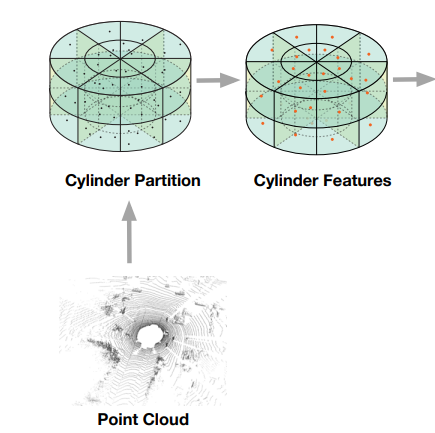
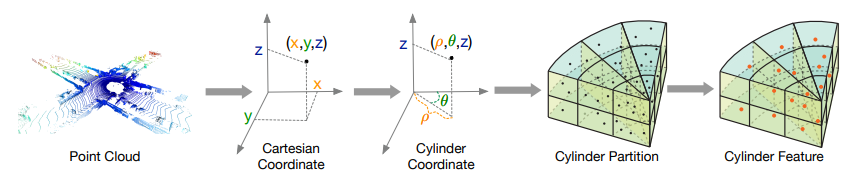

In [ ]:
##########################################################################################
# Net Architecture - First Part                                                          #
##########################################################################################

class cylinder_fea(nn.Module):

    def __init__(self, grid_size, fea_dim=3,
                 out_pt_fea_dim=64, max_pt_per_encode=64, fea_compre=None):
        super(cylinder_fea, self).__init__()

        self.PPmodel = nn.Sequential(
            nn.BatchNorm1d(fea_dim),

            nn.Linear(fea_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, out_pt_fea_dim)
        )

        self.max_pt = max_pt_per_encode
        self.fea_compre = fea_compre
        self.grid_size = grid_size
        kernel_size = 3
        self.local_pool_op = torch.nn.MaxPool2d(kernel_size, stride=1,
                                                padding=(kernel_size - 1) // 2,
                                                dilation=1)
        self.pool_dim = out_pt_fea_dim

        # point feature compression
        if self.fea_compre is not None:
            self.fea_compression = nn.Sequential(
                nn.Linear(self.pool_dim, self.fea_compre),
                nn.ReLU())
            self.pt_fea_dim = self.fea_compre
        else:
            self.pt_fea_dim = self.pool_dim

    def forward(self, pt_fea, xy_ind):
        cur_dev = pt_fea[0].get_device()

        # concate everything
        cat_pt_ind = []
        for i_batch in range(len(xy_ind)):
            cat_pt_ind.append(F.pad(xy_ind[i_batch], (1, 0), 'constant', value=i_batch))

        cat_pt_fea = torch.cat(pt_fea, dim=0)
        cat_pt_ind = torch.cat(cat_pt_ind, dim=0)
        pt_num = cat_pt_ind.shape[0]

        # shuffle the data
        shuffled_ind = torch.randperm(pt_num, device=cur_dev)
        cat_pt_fea = cat_pt_fea[shuffled_ind, :]
        cat_pt_ind = cat_pt_ind[shuffled_ind, :]

        # unique xy grid index
        unq, unq_inv, unq_cnt = torch.unique(cat_pt_ind, return_inverse=True, return_counts=True, dim=0)
        unq = unq.type(torch.int64)

        # process feature
        processed_cat_pt_fea = self.PPmodel(cat_pt_fea)
        pooled_data = torch_scatter.scatter_max(processed_cat_pt_fea, unq_inv, dim=0)[0]

        if self.fea_compre:
            processed_pooled_data = self.fea_compression(pooled_data)
        else:
            processed_pooled_data = pooled_data

        return unq, processed_pooled_data

## Data Builder

In [ ]:
class data_builder:
    def build(dataset_config,
              train_dataloader_config,
              val_dataloader_config,
              grid_size=[480, 360, 32]):
        train_data_path = train_dataloader_config["data_path"]
        val_data_path = val_dataloader_config["data_path"]
        train_imageset = train_dataloader_config["imageset"]
        val_imageset = val_dataloader_config["imageset"]
        train_ref = train_dataloader_config["return_ref"]
        val_ref = val_dataloader_config["return_ref"]

        label_mapping = dataset_config["label_mapping"]

        SemKITTI = get_pc_model_class(dataset_config['pc_dataset_type'])

        nusc=None
        if "nusc" in dataset_config['pc_dataset_type']:
            from nuscenes import NuScenes
            nusc = NuScenes(version='v1.0-trainval', dataroot=data_path, verbose=True)

        train_pt_dataset = SemKITTI(train_data_path, imageset=train_imageset,
                                    return_ref=train_ref, label_mapping=label_mapping, nusc=nusc)
        val_pt_dataset = SemKITTI(val_data_path, imageset=val_imageset,
                                  return_ref=val_ref, label_mapping=label_mapping, nusc=nusc)

        train_dataset = get_model_class_dataset(dataset_config['dataset_type'])(
            train_pt_dataset,
            grid_size=grid_size,
            flip_aug=True,
            fixed_volume_space=dataset_config['fixed_volume_space'],
            max_volume_space=dataset_config['max_volume_space'],
            min_volume_space=dataset_config['min_volume_space'],
            ignore_label=dataset_config["ignore_label"],
            rotate_aug=True,
            scale_aug=True,
            transform_aug=True
        )

        val_dataset = get_model_class_dataset(dataset_config['dataset_type'])(
            val_pt_dataset,
            grid_size=grid_size,
            fixed_volume_space=dataset_config['fixed_volume_space'],
            max_volume_space=dataset_config['max_volume_space'],
            min_volume_space=dataset_config['min_volume_space'],
            ignore_label=dataset_config["ignore_label"],
        )

        train_dataset_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                           batch_size=train_dataloader_config["batch_size"],
                                                           collate_fn=collate_fn_BEV,
                                                           shuffle=train_dataloader_config["shuffle"],
                                                           num_workers=train_dataloader_config["num_workers"])
        val_dataset_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                         batch_size=val_dataloader_config["batch_size"],
                                                         collate_fn=collate_fn_BEV,
                                                         shuffle=val_dataloader_config["shuffle"],
                                                         num_workers=val_dataloader_config["num_workers"])

        return train_dataset_loader, val_dataset_loader

## Loss Builder

In [ ]:
class loss_builder:
    def build(wce=True, lovasz=True, num_class=20, ignore_label=0):

        loss_funs = torch.nn.CrossEntropyLoss(ignore_index=ignore_label)

        if wce and lovasz:
            return loss_funs, lovasz_softmax
        elif wce and not lovasz:
            return wce
        elif not wce and lovasz:
            return lovasz_softmax
        else:
            raise NotImplementedError

## Model Builder

In [ ]:
class model_builder:
    def build(model_config):
        output_shape = model_config['output_shape']
        num_class = model_config['num_class']
        num_input_features = model_config['num_input_features']
        use_norm = model_config['use_norm']
        init_size = model_config['init_size']
        fea_dim = model_config['fea_dim']
        out_fea_dim = model_config['out_fea_dim']

        # Net Architecture - First Part
        cy_fea_net = cylinder_fea(grid_size=output_shape,
                          fea_dim=fea_dim,
                          out_pt_fea_dim=out_fea_dim,
                          fea_compre=num_input_features)

        # Net Architecture - Second Part
        cylinder_3d_spconv_seg = Asymm_3d_spconv(
            output_shape=output_shape,
            use_norm=use_norm,
            num_input_features=num_input_features,
            init_size=init_size,
            nclasses=num_class)


        # Put everything together, call forward and return the model
        model = get_model_class_c3d(model_config["model_architecture"])(
            cylin_model=cy_fea_net,                            # Net Architecture - First Part
            segmentator_spconv=cylinder_3d_spconv_seg,         # Net Architecture - Second Part
            sparse_shape=output_shape                          
        )

        return model

## Load Config and Train

In [ ]:
 def load_model_and_train(config_path, early_stop_patience = 5, early_stop_delta = 0.005):
    
    ################################################################################################################
    # LOAD CONFIGURATION FOR MODEL AND DATASET                                                                     #
    ##################################################L#############################################################
    
    pytorch_device = torch.device('cuda:0')
    configs = load_config_data(config_path)

    dataset_config = configs['dataset_params']
    train_dataloader_config = configs['train_data_loader']
    val_dataloader_config = configs['val_data_loader']

    val_batch_size = val_dataloader_config['batch_size']
    train_batch_size = train_dataloader_config['batch_size']

    model_config = configs['model_params']
    train_hypers = configs['train_params']

    grid_size = model_config['output_shape']
    num_class = model_config['num_class']
    ignore_label = dataset_config['ignore_label']

    model_load_path = train_hypers['model_load_path']
    model_save_path = train_hypers['model_save_path']
    model_save_path_early_stop = train_hypers['model_save_path_early_stop']
    model_save_path_best_val_miou = train_hypers['model_save_path_best_val_miou']

    SemKITTI_label_name = get_SemKITTI_label_name(dataset_config["label_mapping"])
    unique_label = np.asarray(sorted(list(SemKITTI_label_name.keys())))[1:] - 1
    unique_label_str = [SemKITTI_label_name[x] for x in unique_label + 1]

    my_model = model_builder.build(model_config)
    if os.path.exists(model_load_path):
        my_model = load_checkpoint(model_load_path, my_model)
        print("pretrained_checkpoint loaded: " + model_load_path)
    else:
        print("no pretrained_checkpoint loaded.")
        
            

    my_model.to(pytorch_device)
    optimizer = optim.Adam(my_model.parameters(), lr=train_hypers["learning_rate"])

    loss_func, lovasz_softmax = loss_builder.build(wce=True, lovasz=True,
                                                   num_class=num_class, ignore_label=ignore_label)

    train_dataset_loader, val_dataset_loader = data_builder.build(dataset_config,
                                                                  train_dataloader_config,
                                                                  val_dataloader_config,
                                                                  grid_size=grid_size)
    
    ################################################################################################################
    # TRAINING                                                                                                     #
    ################################################################################################################
    
    # params for early stopping
    best_score = None   
    score = 0          
    early_stop = False
    early_stop_counter = 0
    
    # params for training and validation
    epoch = 0
    best_val_miou = 0
    my_model.train()   # set model to train mode
    global_iter = 0
    check_iter = train_hypers['eval_every_n_steps']
    
    # statistics recording
    csv_name = "statistics/training_statistics_" + time.strftime("%Y%m%d-%H%M%S") + ".csv"
    csv_file = open(csv_name, 'a')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['epoch', 'iter', 'train_loss', 'val_loss', 'val_iou_road', 'val_iou_vegetation',
                         'val_iou_building', 'val_iou_terrain', 'val_miou_all_20_classes', 'early_stop_counter'])
    
    
    #############################################
    # TRAIN EPOCH                               #
    #############################################
    while epoch < train_hypers['max_num_epochs'] and not early_stop:
        
       
        loss_list = []
        pbar = tqdm(total=len(train_dataset_loader))
        time.sleep(10)
        # lr_scheduler.step(epoch)
        
        #############################################
        # TRAIN ITERATIONS IN EPOCH                 #
        #############################################
        for i_iter, (_, train_vox_label, train_grid, _, train_pt_fea) in enumerate(train_dataset_loader):
            
            
            #############################################
            # VALIDATION EVERY CHECK_ITER STEPS         #
            #############################################
            if global_iter % check_iter == 0 and epoch >= 1:
                my_model.eval()
                hist_list = []
                val_loss_list = []
                
                csv_file = open(csv_name, 'a')
                csv_writer = csv.writer(csv_file)
                             
                with torch.no_grad():
                    
                    for i_iter_val, (_, val_vox_label, val_grid, val_pt_labs, val_pt_fea) in enumerate(
                            val_dataset_loader):

                        val_pt_fea_ten = [torch.from_numpy(i).type(torch.FloatTensor).to(pytorch_device) for i in
                                          val_pt_fea]
                        val_grid_ten = [torch.from_numpy(i).to(pytorch_device) for i in val_grid]
                        val_label_tensor = val_vox_label.type(torch.LongTensor).to(pytorch_device)
                        val_batch_size = val_vox_label.shape[0]
                        predict_labels = my_model(val_pt_fea_ten, val_grid_ten, val_batch_size, epoch)
                        # aux_loss = loss_fun(aux_outputs, point_label_tensor)
                        loss = lovasz_softmax(torch.nn.functional.softmax(predict_labels).detach(), val_label_tensor,
                                              ignore=0) + loss_func(predict_labels.detach(), val_label_tensor)
                        predict_labels = torch.argmax(predict_labels, dim=1)
                        predict_labels = predict_labels.cpu().detach().numpy()
                        for count, i_val_grid in enumerate(val_grid):
                            hist_list.append(fast_hist_crop(predict_labels[
                                                                count, val_grid[count][:, 0], val_grid[count][:, 1],
                                                                val_grid[count][:, 2]], val_pt_labs[count],
                                                            unique_label))
                        val_loss_list.append(loss.detach().cpu().numpy())
                        
                my_model.train()
                iou = per_class_iu(sum(hist_list))
                
                print('Validation per class iou: ')
                for class_name, class_iou in zip(unique_label_str, iou):
                    if class_name == "road":
                        val_iou_road = class_iou
                    elif class_name == "vegetation":
                        val_iou_vegetation = class_iou
                    elif class_name == "building":
                        val_iou_building = class_iou
                    elif class_name == "terrain":
                        val_iou_terrain = class_iou     
                    print('%s : %.2f%%' % (class_name, class_iou * 100))
                    
                val_miou = np.nanmean(iou) * 100
                del val_vox_label, val_grid, val_pt_fea, val_grid_ten

                # save model if performance is improved
                if best_val_miou < val_miou:
                    best_val_miou = val_miou
                    torch.save(my_model.state_dict(), model_save_path_best_val_miou)

                print('Current val miou is %.3f while the best val miou is %.3f' %
                      (val_miou, best_val_miou))
                print('Current val loss is %.3f' %
                      (np.mean(val_loss_list)))
                
                ######################## 
                # EARLY STOPPING       #
                ########################
                score = -np.mean(val_loss_list)

                if best_score is None:
                    best_score = score
                elif score < best_score + early_stop_delta:
                    early_stop_counter += 1
                    print("Early-stopping counter: " + str(early_stop_counter) + " out of " + str(early_stop_patience))

                    if early_stop_counter >= early_stop_patience:
                        early_stop = False # True <- check without
                else:
                    best_score = score
                    torch.save(my_model.state_dict(), model_save_path_early_stop)
                    early_stop_counter = 0
                    
                csv_writer.writerow([epoch, global_iter, np.mean(loss_list), np.mean(val_loss_list), val_iou_road,
                                     val_iou_vegetation, val_iou_building, val_iou_terrain, val_miou, early_stop_counter])
                csv_file.close()
                
                
            train_pt_fea_ten = [torch.from_numpy(i).type(torch.FloatTensor).to(pytorch_device) for i in train_pt_fea]
            # train_grid_ten = [torch.from_numpy(i[:,:2]).to(pytorch_device) for i in train_grid]
            train_vox_ten = [torch.from_numpy(i).to(pytorch_device) for i in train_grid]
            point_label_tensor = train_vox_label.type(torch.LongTensor).to(pytorch_device)
            train_batch_size = train_vox_label.shape[0]
            
            # forward + backward + optimize
            # v2 uses epoch as iter for softmax temperature annealing
            outputs = my_model(train_pt_fea_ten, train_vox_ten, train_batch_size, epoch)
            loss = lovasz_softmax(torch.nn.functional.softmax(outputs), point_label_tensor, ignore=0) + loss_func(
                outputs, point_label_tensor)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

            if global_iter % 1000 == 0:
                if len(loss_list) > 0:
                    print('epoch %d iter %5d, loss: %.3f\n' %
                          (epoch, i_iter, np.mean(loss_list)))
                else:
                    print('loss error')

            optimizer.zero_grad()
            sys.stdout.flush()
            pbar.update(1)
            global_iter += 1
            if global_iter % check_iter == 0:
                if len(loss_list) > 0:
                    print('epoch %d iter %5d, loss: %.3f\n' %
                          (epoch, i_iter, np.mean(loss_list)))
                else:
                    print('loss error')
                    
                    
        pbar.close()
        epoch += 1

## Train the Model

In [ ]:
#load_model_and_train("config/sbld.yaml", early_stop_patience = 10, early_stop_delta = 0.005)
load_model_and_train("config/semantickitti.yaml", early_stop_patience = 30, early_stop_delta = 0.005)